Amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below:
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

In [ ]:
#in this you need two files reviews.csv and tokenization file

In [ ]:
#review file 
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt

#tokenization.py
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:04<00:00, 72.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 21.5MB/s]


In [ ]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


In [ ]:
tf.test.gpu_device_name() #testing for availability of GPU

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [ ]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews[['Text','Score']]
check_nan = reviews.isnull().sum()
 
# printing the result
print(check_nan)

Text     0
Score    0
dtype: int64


In [ ]:
reviews.shape

(568454, 2)

In [ ]:
print(len(reviews.loc[reviews['Score'] == 3,'Score']))

42640


In [ ]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 
#DataFrame.loc[condition, column_name] = new_value


reviews.loc[reviews['Score'] <=2,'Score'] = 0
reviews.loc[reviews['Score']>3,'Score'] = 1
reviews.drop(reviews[reviews['Score'] ==3].index, inplace=True)
print(reviews.shape)

(525814, 2)


In [ ]:
reviews.tail()

,Text,Score
568449,Great for sesame chicken..this is a good if no...,1
568450,I'm disappointed with the flavor. The chocolat...,0
568451,"These stars are small, so you can give 10-15 o...",1
568452,These are the BEST treats for training and rew...,1
568453,"I am very satisfied ,product is as advertised,...",1


<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [ ]:
#considering only those data whose text length is less than 50 


def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [ ]:
print(reviews.shape)

(100000, 3)


In [ ]:
print(max(reviews['len']))

49


In [ ]:
#remove HTML from the Text column and save in the Text column only
def remove_tags(string):
    result = re.sub('<[^<]+?>','',string)
    return result
reviews['Text']=reviews['Text'].apply(lambda text : remove_tags(text))
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 64117 to 19261
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    100000 non-null  object
 1   Score   100000 non-null  int64 
 2   len     100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [ ]:
#print head 5
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


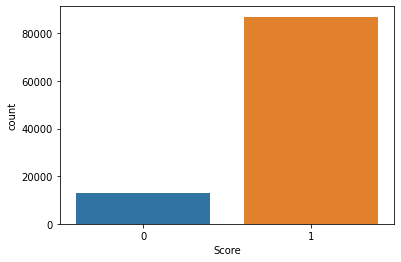

In [ ]:
X = reviews[['Text','len']]
Y = reviews['Score']

sns.countplot(data = reviews, x='Score')

In [ ]:
#split the data into train and test data(20%) with stratify sampling, setting random state 33, 

X_train,X_test,y_train,y_test = train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=33)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(80000, 2) (80000,)
(20000, 2) (20000,)


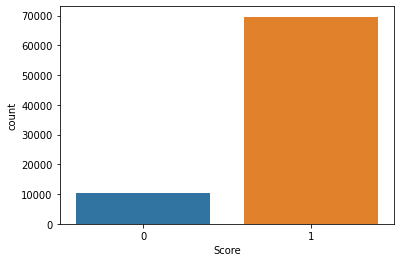

In [ ]:
#plot bar graphs of y_train and y_test
sns.countplot(x=y_train)

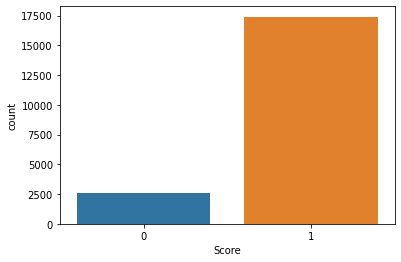

In [ ]:
sns.countplot(x=y_test)

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

 To know more about BERT: <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

> This model has been pre-trained for English on the Wikipedia and BooksCorpus. 
> Text inputs have been normalized the "uncased" way, meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped.
> For training, random input masking has been applied independently to word pieces (as in the original BERT paper). </pre>

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
#tokenized words as input
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
#masked input
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#The model we are building is classification all we need is the pooled outputs
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
# ref: https://stackoverflow.com/questions/63377198/what-is-the-difference-between-pooled-output-and-sequence-output-in-bert-layer#:~:text=Pooled%20output%20is%20the%20embedding%20of%20the%20%5BCLS%5D,details%2C%20please%20refer%20to%20the%20BERT%20original%20paper.


In [ ]:
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

bert_model.summary()


In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

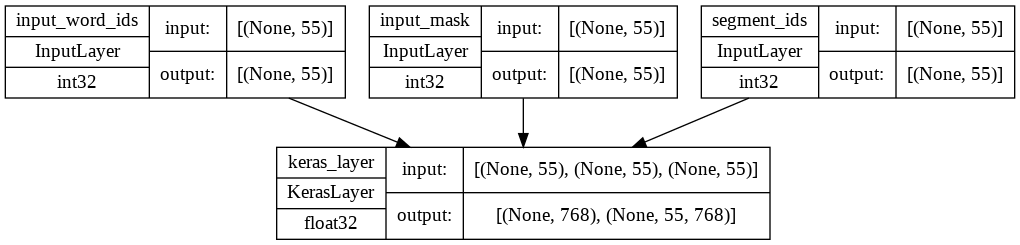

In [ ]:
tf.keras.utils.plot_model(bert_model, show_shapes=True, show_dtype=True)

<pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
#Sentence tokenization: Breaking a text into individual sentences.
!pip3 install sentencepiece
!pip3 install tf_sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.6 MB/s 


In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation


In [ ]:
#We have given tokenization.py file


import tokenization
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )
print(type(tokenizer))

<class 'tokenization.FullTokenizer'>


In [ ]:
tokenizer.tokenize('Where are you going?') 

['where', 'are', 'you', 'going', '?']

In [ ]:
len(tokenizer.vocab)

30522

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

How to implememt tokenization : 
1. Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 
2. add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
3. maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
4.if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)
5. Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
6. it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
7. a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)
[ type of all the above arrays should be numpy arrays]
8.after execution of this cell, you have to get X_train_tokens, X_train_mask, X_train_segment  X_test_tokens, X_test_mask, X_test_segment

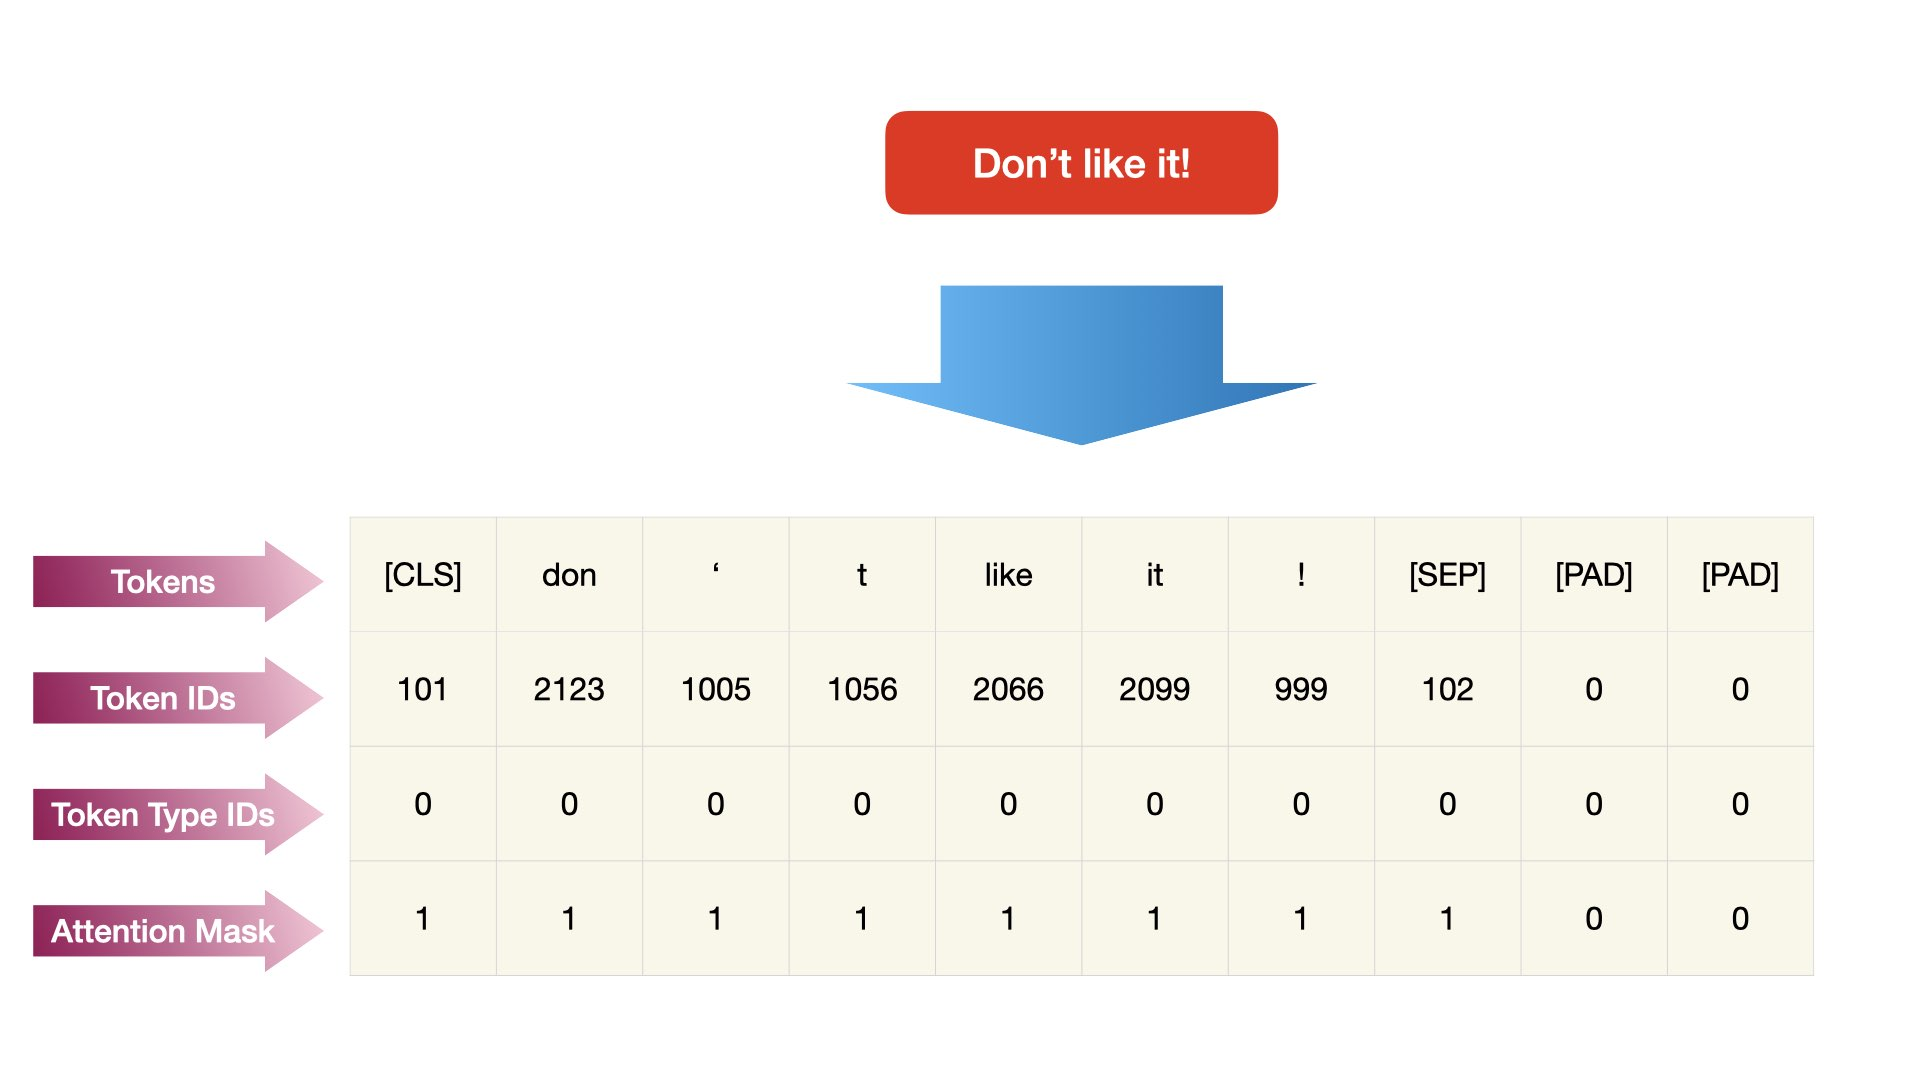

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
max_len_x_train = max([len for len in X_train['len']])
max_len_x_test = max([len for len in X_test['len']])
                     
print("Max len of text in X_train = ",max_len_x_train)
print("Max len of text in X_test  = ",max_len_x_test)

Max len of text in X_train =  49
Max len of text in X_test  =  49


> sample conversion

In [ ]:
from tensorflow.python.ops.gradient_checker_v2 import max_error


original_text = X_train['Text'].values[0]
print(original_text)
original_len = len(X_train['Text'].values[0].split())
print("orginal length = ",original_len)
print("###"*50)

#Tokenization is an important step in natural language processing and text analysis, 
#  as it enables the computer to analyze and understand the text by breaking it down into smaller, more manageable pieces.
print("Performing tokenization...")
x_token = tokenizer.tokenize(X_train['Text'].values[0]) 
x_token = x_token[0:(max_seq_length-2)]
print(len(x_token))
print(x_token)
print("###"*50)

#[CLS] stands for "classification" and is used as a special token at the beginning of a text sequence
#[SEP] stands for "separator" and is used to separate different sentences or sequences in a text.
print("Adding cls and sep...")
add_ = ['[CLS]',*x_token,'[SEP]']
print(add_)
print(len(add_))
print("###"*50)

#By adding the positional encoding to the input embeddings, 
#  BERT is able to capture not only the meaning of individual words but also their relative positions in the input sequence,
print("Converting tokens into ids(positional encodings...)")
token_ids = np.array(tokenizer.convert_tokens_to_ids(add_)+[0]*(max_seq_length-len(add_)))
print(token_ids)
print(len(token_ids))
print("###"*50)


#Masking refers to the process of randomly replacing some of the input tokens with a special [MASK] token during pre-training.
# The [MASK] token used in MLM is not included in the input during fine-tuning of the BERT model for downstream NLP tasks such as text classification or named entity recognition.
# Instead, the model is trained to predict the original tokens based on the context of the surrounding tokens.
print("Masking the data...")
mask = np.array([1]*len(add_)+[0]*(max_seq_length-len(add_)))
print(mask)
print(len(mask))
print("###"*50)


#If we are sending two sentences at the same time then in order separate them we use segmentation, here are only one sentence is sent we mask all the text with zeros
print("segmenting...")
seg = np.array([0]*max_seq_length)
print(seg)
print(len(seg))




I had never tried this brand before, so I was worried about the quality.  It tasted great.  A very nice smooth rich full flavor.  Its my new favoret.
orginal length =  28
######################################################################################################################################################
Performing tokenization...
34
['i', 'had', 'never', 'tried', 'this', 'brand', 'before', ',', 'so', 'i', 'was', 'worried', 'about', 'the', 'quality', '.', 'it', 'tasted', 'great', '.', 'a', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor', '.', 'its', 'my', 'new', 'favor', '##et', '.']
######################################################################################################################################################
Adding cls and sep...
['[CLS]', 'i', 'had', 'never', 'tried', 'this', 'brand', 'before', ',', 'so', 'i', 'was', 'worried', 'about', 'the', 'quality', '.', 'it', 'tasted', 'great', '.', 'a', 'very', 'nice', 'smooth', 'rich', 'full', 'flavor

Here are some details to pay attention to:
- `input_mask` The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a 1 anywhere the `input_word_ids` is not padding.
- `input_type_ids` has the same shape as `input_mask`, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

In [ ]:
def perform_tokenization(input_data,tokenizer):

    input_data_tokens  = []
    input_data_mask    = []
    input_data_segment = []

    for reviews in tqdm(input_data.Text):
  
        tokens = tokenizer.tokenize(reviews)                     # split words in review
        if len(tokens) >= 54:                                    # if length of sentence is greater than 54, truncate
            tokens = tokens[:53]
        tokens = ['[CLS]',*tokens,'[SEP]']                       # add ['CLS'] to start and ['SEP'] to the end
        
        if len(tokens)<55:                                       # if length of sentence is less than 55           
            while len(tokens) < 55:                              # add the word ['PAD'] in remaining places
                tokens.append('[PAD]')                                            
        
        masked=[]
        for i in tokens:
            if i!='[PAD]':                                       # fill mask_array with 0 in place of ['PAD'] and 1 otherwise
                masked.append(1)
            else:
                masked.append(0)
        input_data_mask.append(masked)
    
        tokens = tokenizer.convert_tokens_to_ids(tokens)         # adding positional encoding to words
        input_data_tokens.append(tokens)    
    
        segment = [0]*55                                         # since inputting only 1 sentence giving segments as all zeroes
        input_data_segment.append(segment)

    input_data_tokens  =  np.array(input_data_tokens)
    input_data_mask    =  np.array(input_data_mask)
    input_data_segment =  np.array(input_data_segment)

    return input_data_tokens,input_data_mask,input_data_segment

In [ ]:
X_train_tokens,X_train_mask,X_train_segment = perform_tokenization(X_train,tokenizer)


  0%|          | 0/80000 [00:00<?, ?it/s]

In [ ]:
print(X_train_tokens.shape)
print(X_train_mask.shape)
print(X_train_segment.shape)

(80000, 55)
(80000, 55)
(80000, 55)


In [ ]:
#checking some random text

print(len(X_train_tokens))
print(X_train_tokens[46])
print(len(X_train_tokens[46]))
print()
print("###"*50)
print(len(X_train_mask))
print(X_train_mask[46])
print(len(X_train_mask[46]))
print()
print("###"*50)
print(len(X_train_segment))
print(X_train_segment[46])

80000
[  101  2009  1005  1055  2025  2242  1045  2052  5373  5309  1012  6970
 16643  3070  2135  1010  1996  5909  5898  2015  2020  2908  1999  2460
  2344   999  2026  2093  3337  3866  2068  1012  2057  2066  1996 19804
 11261  2102 14894  1010  2021  2070  3920  2336  2089  9544  1996  5909
  3771 26389  1012   102     0     0     0]
55

######################################################################################################################################################
80000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
55

######################################################################################################################################################
80000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
X_test_tokens,X_test_mask,X_test_segment = perform_tokenization (X_test,tokenizer)
  

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
print(X_test.values[55])
print()
print("###"*50)
print(len(X_test_tokens))
print(X_test_tokens[55])
print(len(X_test_tokens[55]))
print()
print("###"*50)
print(len(X_test_mask))
print(X_test_mask[55])
print(len(X_test_mask[55]))
print()
print("###"*50)
print(len(X_test_segment))
print(X_test_segment[55])

['Alert:  In the event your dog is allergic to fish, be aware that the third ingredient in Newman\'s Own Organic Chicken and Brown Rice Formula canned pet food for dogs, after "Organic Chicken" and "Sufficient Water for Processing," is "Ocean Whitefish."'
 41]

######################################################################################################################################################
20000
[  101  9499  1024  1999  1996  2724  2115  3899  2003 27395  2000  3869
  1010  2022  5204  2008  1996  2353 21774  1999 10625  1005  1055  2219
  7554  7975  1998  2829  5785  5675 27141  9004  2833  2005  6077  1010
  2044  1000  7554  7975  1000  1998  1000  7182  2300  2005  6364  1010
  1000  2003  1000  4153  2317  7529   102]
55

######################################################################################################################################################
20000
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

In [ ]:
print(X_test_tokens.shape)
print(X_test_mask.shape)
print(X_test_segment.shape)

(20000, 55)
(20000, 55)
(20000, 55)


In [ ]:
##save all your results to disk so that, no need to run all again. 
import pickle
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
X_train_tokens

array([[ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 1045, 2293, ..., 2003, 2307,  102],
       [ 101, 2023, 2003, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2318, ..., 2987, 1005,  102],
       [ 101, 2026, 2344, ..., 2262, 1012,  102],
       [ 101, 1037, 7965, ...,    0,    0,    0]])

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output = bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

2500/2500 [==============================] - 316s 125ms/step


In [ ]:
X_train_pooled_output.shape

(80000, 768)

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

625/625 [==============================] - 78s 125ms/step


In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> Using AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
3. Using tensorboard to log all your metrics and Losses. 
4. Print the loss and metric at every epoch. 
</pre>

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import datetime 
from tensorflow.keras.utils import to_categorical

In [ ]:
def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                      monitor ='val_loss',
                                                      verbose= 1,
                                                      save_best_only = True,
                                                      mode = 'max')

In [ ]:
early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows

input_layer=Input(shape=(X_train_pooled_output.shape[1],))

x = Dense(units=128,activation='relu',kernel_initializer ='he_normal')(input_layer)

x = Dense(units=128,activation='relu',kernel_initializer='he_normal')(x)

x = Dense(units=64,activation='relu',kernel_initializer='he_normal')(x)

x = Dense(units=32,activation='relu',kernel_initializer='he_normal')(x)

output_layer = Dense(2,activation='softmax')(x)

model = Model(inputs=input_layer,outputs=output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 125,346
Trainable params: 125,346
Non-trainab

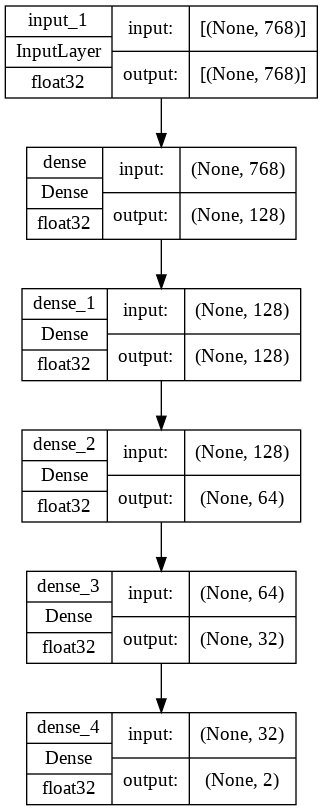

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
y_train_ohe = to_categorical(y_train)  
y_test_ohe = to_categorical(y_test)

y_test_ohe

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
%load_ext tensorboard

model.compile(optimizer='Adam',
              loss='categorical_crossentropy' ,
              metrics=['accuracy',auc])

## TENSORBOARD callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train_pooled_output,
          y_train_ohe,
          epochs=5,
          batch_size=128,
          validation_data=(X_test_pooled_output,y_test_ohe),
          callbacks = [tensorboard_callback,model_checkpoint,early_Stopping] )




Epoch 1/5
624/625 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.8977 - auc: 0.9042
Epoch 1: val_loss improved from -inf to 0.22269, saving model to /tmp/checkpoint
625/625 [==============================] - 10s 15ms/step - loss: 0.2522 - accuracy: 0.8978 - auc: 0.9042 - val_loss: 0.2227 - val_accuracy: 0.9097 - val_auc: 0.9347
Epoch 2/5
617/625 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9175 - auc: 0.9465
Epoch 2: val_loss did not improve from 0.22269
625/625 [==============================] - 4s 6ms/step - loss: 0.1995 - accuracy: 0.9175 - auc: 0.9465 - val_loss: 0.1867 - val_accuracy: 0.9253 - val_auc: 0.9449
Epoch 3/5
615/625 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9199 - auc: 0.9498
Epoch 3: val_loss did not improve from 0.22269
625/625 [==============================] - 4s 6ms/step - loss: 0.1961 - accuracy: 0.9196 - auc: 0.9497 - val_loss: 0.2019 - val_accuracy: 0.9237 - val_auc: 0.9449
Epoch 4

In [ ]:
tensorboard --logdir logs/fit


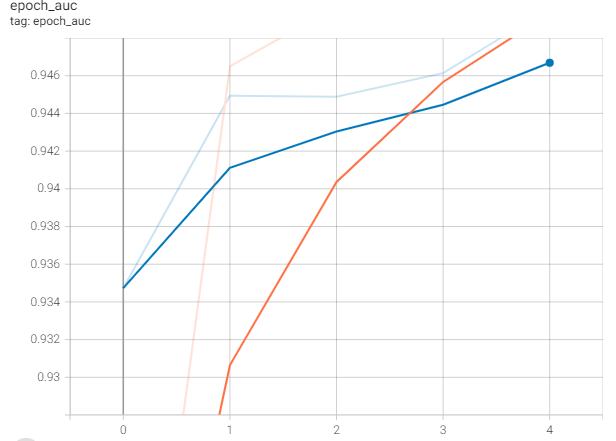

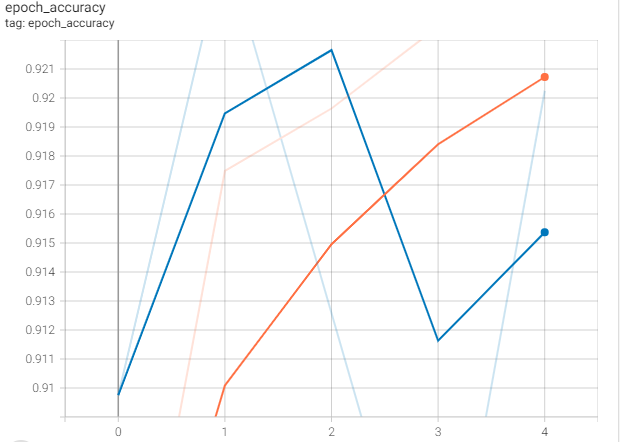

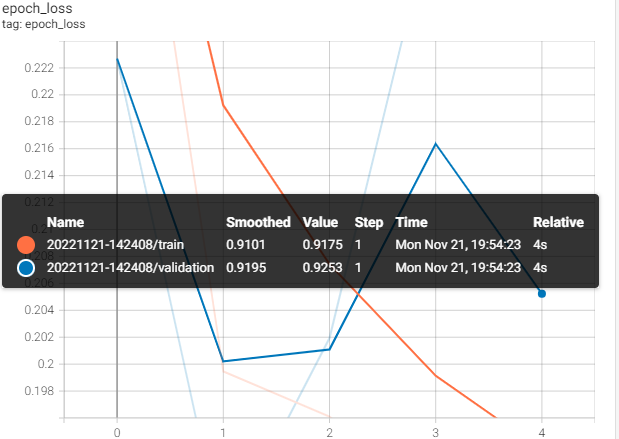

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as 
!gdown --id 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 70.2MB/s]


In [ ]:
#read the csv file
test_df= pd.read_csv('test.csv')

In [ ]:
test_df.shape

(352, 1)

In [ ]:
test_df.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    352 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB




[data pipeline](https://hevodata.com/learn/data-pipeline/)


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [ ]:
def data_pipeline(data,trained_model,params):
  data.dropna(subset = ["Text"], inplace=True) 

  #Remove all the html tags
  data['Text'] = data['Text'].str.replace(r'<[^<>]*>', '', regex=True)

   #Now do tokenization
  data_token,data_mask,data_segment = perform_tokenization(data,params)
   
  #Get Embeddings from BERT Model
  X_test = trained_model.predict([data_token,data_mask,data_segment])
  
  print("shape of the output is =",X_test.shape)
  return X_test

                                   

In [ ]:
X_test = data_pipeline(data = test_df, trained_model=bert_model, params=tokenizer)

  0%|          | 0/352 [00:00<?, ?it/s]

11/11 [==============================] - 1s 127ms/step
shape of the output is = (352, 768)


In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

11/11 [==============================] - 0s 2ms/step


In [ ]:
test_df['labels'] = y_pred

In [ ]:
test_df

,Text,labels
0,Just opened Greenies Joint Care (individually ...,0
1,This product rocks :) My mom was very happy w/...,1
2,"The product was fine, but the cost of shipping...",1
3,I love this soup. It's great as part of a meal...,1
4,Getting ready to order again. These are great ...,1
...,...,...
347,Without a doubt this is by far the BEST beef g...,1
348,My 8 month old loves these. He hardly swallows...,1
349,the flavor palet for this coffee is deep and r...,1
350,This is the best granola my family has ever ha...,1


In [ ]:
test_df['labels'].value_counts()

1    324
0     28
Name: labels, dtype: int64

## CHECKING SOME SMAPLES

In [ ]:
test_df['Text'][0]

'Just opened Greenies Joint Care (individually sealed) in December 2011 and found small worm crawling all over it.  Next one looked fine, but really supposed to trust these now?'

In [ ]:
test_df['labels'][0]

0

In [ ]:
test_df['Text'][350]

"This is the best granola my family has ever had.  We cannot imagine eating another brand.  Not always easy to find in the store, since it is so popular, it is usually sold out.  Men's Health listed it as a favorite food recently.  Great in yogurt or with milk."

In [ ]:
test_df['labels'][350]

1

## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.



> The task which we performed is the sentiment analysis means predicting whether a review is positive or negative, here the prediction is done based on the scores 

> Text column which is unstructured data can be analyzed using TF-IDF, LSTMs or BERT.

> Here we used BERT as our model

> BERT model we considered is imported from TensorflowHub, which is a pre-trained model (we can also import BERT from hugging face [link](https://huggingface.co/)

> BERT MODEL IS IMPLEMENTED AS :
1. BERT considers three inputs: 
- Tokenized input(sentence-> words -> integers), tokenization is done from a pre-trained vocabulary dictionary.
      - important thing during tokenization is adding [CLS] at starting of sentence and [SEP] at end , so that model can know when the sentence started and when it ends

   - Masked input (our_data->1 and pad_data->0), masking helps model to differentiate between  real data with padded data.

   - Segmented data (single sentence as input-> 0, more than one sentence: 1st sentence->0, 2nd sentence->1), since here we are considering only single sentence we are making all values to zero(0)
   
2. These three inputs are fed into the model and depending upon the problem we are solving the outputs are considered:
        - CLASSIFICATION: POOLED OUTPUTS
        - OTHER TASKS :SEQUENCE OUTPUTS

Here our task is classification/sentiment analysis we considered pooled outputs

3. The pooled ouputs are now fed into another neural network to generate the desired outputs.

THE ABOVE TASK WE HAD DONE IS PRE-TRAINING 

4. Last step, we tested the model with the test data by data-piplining and the sentiment analysis of test data is genereted.

        1 -->positive review
        0 --> negative review
